<a href="https://colab.research.google.com/github/robinjameslee/Plotting_Volatility_Smile/blob/main/Plotting_Volatility_Smile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [16]:
ticker = 'TSLA'
tk = yf.Ticker(ticker)
expiry_dates = tk.options

In [17]:
#Here we could have a look which options expiry dates we have in our dataset
expiry_dates

('2023-03-10',
 '2023-03-17',
 '2023-03-24',
 '2023-03-31',
 '2023-04-06',
 '2023-04-21',
 '2023-05-19',
 '2023-06-16',
 '2023-07-21',
 '2023-09-15',
 '2023-11-17',
 '2023-12-15',
 '2024-01-19',
 '2024-03-15',
 '2024-06-21',
 '2024-09-20',
 '2025-01-17',
 '2025-06-20')

In [18]:
#We can also have a look what data do we have for each calls/puts for each expiry
df = pd.DataFrame(tk.option_chain(expiry_dates[0]).calls)
df

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,TSLA230310C00015000,2023-02-09 18:41:26+00:00,15.0,196.16,182.65,182.95,0.0,0.0,11.0,3,5.937503,True,REGULAR,USD
1,TSLA230310C00020000,2023-02-09 18:43:52+00:00,20.0,191.37,177.65,178.00,0.0,0.0,NaN,3,5.875003,True,REGULAR,USD
2,TSLA230310C00030000,2023-02-09 15:23:16+00:00,30.0,183.58,167.65,168.00,0.0,0.0,NaN,3,4.828129,True,REGULAR,USD
3,TSLA230310C00040000,2023-02-02 15:39:33+00:00,40.0,152.10,157.60,158.10,0.0,0.0,2.0,0,4.328130,True,REGULAR,USD
4,TSLA230310C00050000,2023-03-02 15:29:57+00:00,50.0,141.26,147.65,148.00,0.0,0.0,102.0,102,3.531251,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,TSLA230310C00320000,2023-03-03 20:58:41+00:00,320.0,0.01,0.00,0.01,0.0,0.0,517.0,6464,1.062505,False,REGULAR,USD
82,TSLA230310C00330000,2023-03-03 18:58:55+00:00,330.0,0.01,0.00,0.01,0.0,0.0,595.0,957,1.125004,False,REGULAR,USD
83,TSLA230310C00340000,2023-03-03 18:39:33+00:00,340.0,0.01,0.00,0.01,0.0,0.0,407.0,990,1.187504,False,REGULAR,USD
84,TSLA230310C00350000,2023-03-03 17:11:53+00:00,350.0,0.01,0.00,0.01,0.0,0.0,16.0,1657,1.250004,False,REGULAR,USD


In [50]:
#Combine everything into one function
def options_chain(ticker):
    tk = yf.Ticker(ticker)
    expiry_dates = tk.options
    options_df = pd.DataFrame()
    for e in expiry_dates:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expiryDate'] = pd.to_datetime(e)
        options_df = options_df.append(opt, ignore_index=True)

    # options_df['expiryDate'] = pd.to_datetime(options_df['expiryDate']) #+ datetime.timedelta(days = 1)
    # options_df['impliedVolatility'] = options_df['impliedVolatility'].map(lambda x: '{0:.2f}%'.format(x * 100))
    options_df['day_to_maturity'] = (options_df['expiryDate'] - datetime.datetime.today()).dt.days
    options_df['optionType'] = options_df['contractSymbol'].str[4:].apply(lambda x: 'call' if 'C' in x else 'put')
    options_df[['bid', 'ask', 'strike']] = options_df[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options_df['mid'] = (options_df['bid'] + options_df['ask']) / 2
    options_df = options_df.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])
    return options_df

In [51]:
tk_options = options_chain(ticker)
tk_options

,contractSymbol,strike,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expiryDate,day_to_maturity,optionType,mid
0,TSLA230310C00015000,15.0,182.65,182.95,11.0,3.0,5.937503,True,2023-03-10,5,call,182.800
1,TSLA230310C00020000,20.0,177.65,178.00,NaN,3.0,5.875003,True,2023-03-10,5,call,177.825
2,TSLA230310C00030000,30.0,167.65,168.00,NaN,3.0,4.828129,True,2023-03-10,5,call,167.825
3,TSLA230310C00040000,40.0,157.60,158.10,2.0,0.0,4.328130,True,2023-03-10,5,call,157.850
4,TSLA230310C00050000,50.0,147.65,148.00,102.0,102.0,3.531251,True,2023-03-10,5,call,147.825
...,...,...,...,...,...,...,...,...,...,...,...,...
4757,TSLA250620P00370000,370.0,178.70,181.35,2.0,441.0,0.362555,True,2025-06-20,838,put,180.025
4758,TSLA250620P00380000,380.0,188.00,190.25,20.0,159.0,0.358145,True,2025-06-20,838,put,189.125
4759,TSLA250620P00390000,390.0,196.55,199.50,2.0,158.0,0.357123,True,2025-06-20,838,put,198.025
4760,TSLA250620P00400000,400.0,205.55,208.65,5.0,138.0,0.353705,True,2025-06-20,838,put,207.100


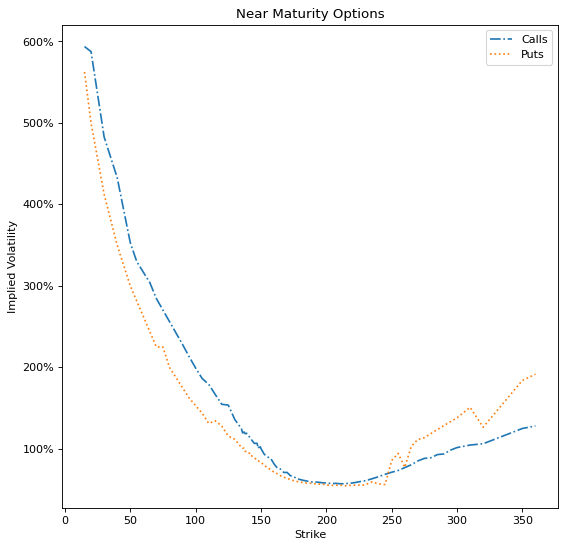

In [64]:
#We can plot the near matuirty options' vol chart
near_maturity_calls = tk_options[(tk_options['expiryDate'] == expiry_dates[0]) & (tk_options['optionType'] == 'call')]
near_maturity_puts = tk_options[(tk_options['expiryDate'] == expiry_dates[0]) & (tk_options['optionType'] == 'put')]

plt.figure(num=None, figsize=(8, 8), dpi=80)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.plot(near_maturity_calls['strike'], near_maturity_calls['impliedVolatility'], label = 'Calls', linestyle = '-.')
plt.plot(near_maturity_puts['strike'], near_maturity_puts['impliedVolatility'], label = 'Puts', linestyle = ':')
plt.legend()
plt.title('Near Maturity Options')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.show()